In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Read files:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print(train.shape, test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


In [4]:
print(data.isnull().sum())
print(data.describe())
print(data.apply(lambda x: len(x.unique())))

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64
        Item_Weight  Item_Visibility      Item_MRP  Outlet_Establishment_Year  \
count  11765.000000     14204.000000  14204.000000               14204.000000   
mean      12.792854         0.065953    141.004977                1997.830681   
std        4.652502         0.051459     62.086938                   8.371664   
min        4.555000         0.000000     31.290000                1985.000000   
25%        8.710000         0.027036     94.012000                1987.000000   
50%       12.600000         0.054021    142.247000         

In [5]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s'%col)
    print(data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

F

In [6]:
#Determine the average weight per item:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

In [7]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 

In [8]:
#Impute data and check #missing values before and after imputation to confirm
print('\nOrignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight['Item_Weight'][x])
print('Final #missing: %d'% sum(data['Item_Weight'].isnull()))


Orignal #missing: 2439
Final #missing: 0


In [9]:
#Import mode function:
from scipy.stats import mode

In [10]:
#Determing the mode for each
outlet_size_mode = data.pivot_table(
        values='Outlet_Size', 
        index='Outlet_Type', 
        aggfunc=(lambda x: mode(x.dropna(), nan_policy='omit')[0])
        )
print('Mode for each Outlet_Type:')
print(outlet_size_mode)

Mode for each Outlet_Type:
                  Outlet_Size
Outlet_Type                  
Grocery Store           Small
Supermarket Type1       Small
Supermarket Type2      Medium
Supermarket Type3      Medium


In [11]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

In [12]:
#Impute data and check #missing values before and after imputation to confirm
print('\nOrignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode['Outlet_Size'][x])
print('\nNow missing:',sum(data['Outlet_Size'].isnull()))


Orignal #missing: 4016

Now missing: 0


In [13]:
print(data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type'))

                   Item_Outlet_Sales
Outlet_Type                         
Grocery Store             339.828500
Supermarket Type1        2316.181148
Supermarket Type2        1995.498739
Supermarket Type3        3694.038558


In [14]:

#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', columns='Item_Identifier')

In [15]:

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

In [16]:
print('\nNumber of 0 values initially: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg[x])
print('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))


Number of 0 values initially: 879
Number of 0 values after modification: 0


In [17]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg[x['Item_Identifier']], axis=1)
print(data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


In [18]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
print('\nItem types combined')
print(data['Item_Type_Combined'].value_counts())


Item types combined
Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64


In [19]:
#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
print('\nYears of operation since 2013')
print(data['Outlet_Years'].describe())


Years of operation since 2013
count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64


In [20]:
#Change categories of low fat:
print('\nFat - Original Categories:')
print(data['Item_Fat_Content'].value_counts())


Fat - Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64


In [21]:
print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())


Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [22]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
print(data['Item_Fat_Content'].value_counts())

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64


In [23]:
#Import library:
from sklearn.preprocessing import LabelEncoder

In [24]:

le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [25]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])
    
print('\n', data.dtypes, '\n')
print(data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10))


 Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8

In [26]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

In [27]:
import copy
#Divide into test and train:
train = copy.deepcopy(data.loc[data['source']=="train"])
test = copy.deepcopy(data.loc[data['source']=="test"])

In [28]:
#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

In [29]:
#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

In [30]:
#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

In [31]:
#Define a dataframe with IDs for submission:
base1 = copy.deepcopy(test[['Item_Identifier','Outlet_Identifier']])
base1['Item_Outlet_Sales'] = mean_sales

In [32]:
#Export submission file
base1.to_csv("alg0.csv",index=False)

In [33]:

#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import metrics, model_selection
import seaborn as sns

In [34]:
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = model_selection.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    #Print model report:
    scores = model_selection.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

Accuracy: 0.56 (+/- 0.05)

Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 44.6 | Min - 1076 | Max - 1217


"\nfrom sklearn.tree import DecisionTreeRegressor\npredictors = [x for x in train.columns if x not in [target]+IDcol]\nalg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)\nmodelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')\ncoef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)\ncoef3.plot(kind='bar', title='Feature Importances', figsize=(10,5))\nfrom sklearn.tree import DecisionTreeRegressor\npredictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']\nalg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)\nmodelfit(alg4, train, test, predictors, target, IDcol, 'alg4.csv')\ncoef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)\ncoef4.plot(kind='bar', title='Feature Importances', figsize=(10,5))\npredictors = [x for x in train.columns if x not in [target]+IDcol]\nalg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)\nmodelfit(alg5, train, test

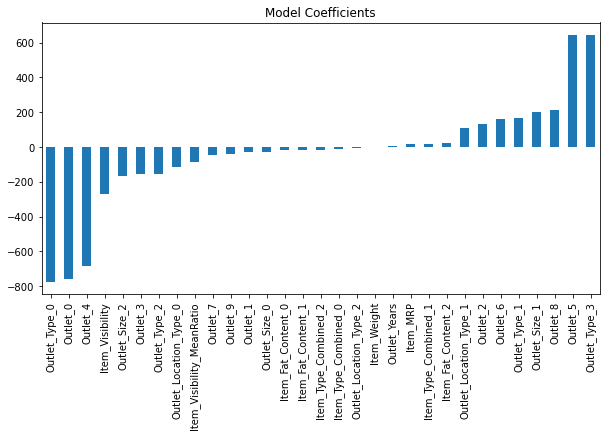

In [36]:
"""
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients', figsize=(10,5))
"""
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients', figsize=(10,5))
"""
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances', figsize=(10,5))
from sklearn.tree import DecisionTreeRegressor
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg4, train, test, predictors, target, IDcol, 'alg4.csv')
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances', figsize=(10,5))
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances', figsize=(10,5))
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(alg6, train, test, predictors, target, IDcol, 'alg6.csv')
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances', figsize=(10,5))
"""